### Step 1: Importing Packages and Reading Data

In [1]:
#Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

#Importing Pandas and Numpy packages
import pandas as pd, numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics

pd.set_option('display.max_columns', 200)

In [2]:
loan_train = pd.read_csv('train.csv')
loan_train.head()

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y  
3             1.0         Urban           Y  
4             1.0         Urban           Y

### Step 2. Inspecting the Dataset

In [3]:
loan_train.shape

(614, 13)

#### Setting the Load ID as the index 

In [4]:
loan_train.set_index('Loan_ID', inplace = True)

#### Checking Data Imbalance

In [5]:
loan_train.Loan_Status.value_counts(normalize = True)*100

Y    68.729642
N    31.270358
Name: Loan_Status, dtype: float64

### Step 3: Checking the Missing values and Imputing them

In [6]:
loan_train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

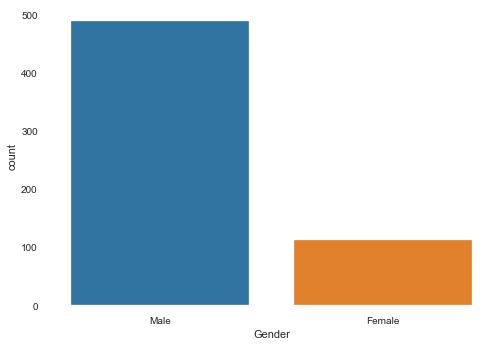

In [7]:
sns.countplot(loan_train.Gender)
plt.show()

In [8]:
loan_train.Gender.fillna(loan_train.Gender.mode()[0], inplace = True)

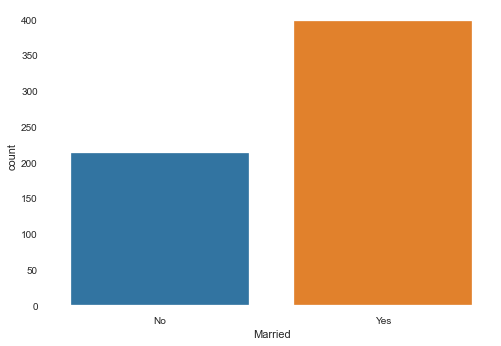

In [9]:
sns.countplot(loan_train.Married)
plt.show()

In [10]:
loan_train.Married.fillna(loan_train.Married.mode()[0], inplace = True)

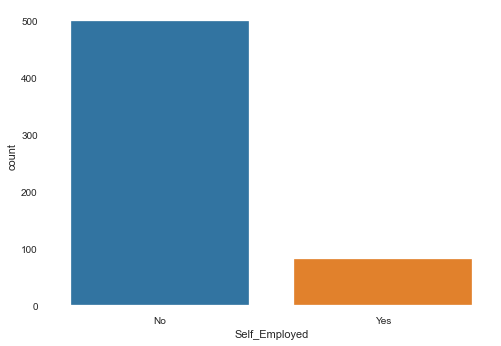

In [11]:
sns.countplot(loan_train.Self_Employed)
plt.show()

In [12]:
loan_train.Self_Employed.fillna(loan_train.Self_Employed.mode()[0], inplace = True)

#### Columns Dependents , Loan Amount, Loan Amount Term cannot be imputed hence we will just remove the missing columns from the Dataset

In [13]:
loan_train = loan_train[~loan_train.Dependents.isnull()]

In [14]:
loan_train = loan_train[~loan_train.LoanAmount.isnull()]

In [15]:
loan_train = loan_train[~loan_train.Loan_Amount_Term.isnull()]

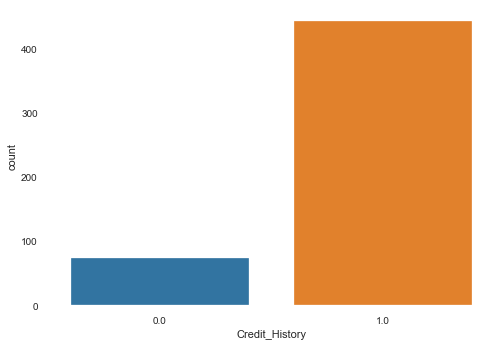

In [16]:
sns.countplot(loan_train.Credit_History)
plt.show()

In [17]:
loan_train.Credit_History.fillna(loan_train.Credit_History.mode()[0], inplace = True)

In [18]:
loan_train.shape

(566, 12)

### Step 4: Data Preparation

#### Converting Categorical (Yes/No) to Binary (1/0)

In [19]:
varlist = ['Married', 'Self_Employed', 'Loan_Status']
def binary_map(x):
    return x.map({'Yes': 1, "No": 0, 'Y': 1, 'N': 0})


loan_train[varlist] = loan_train[varlist].apply(binary_map)

In [20]:
loan_train.head()

Gender  Married Dependents     Education  Self_Employed  \
Loan_ID                                                            
LP001003   Male        1          1      Graduate              0   
LP001005   Male        1          0      Graduate              1   
LP001006   Male        1          0  Not Graduate              0   
LP001008   Male        0          0      Graduate              0   
LP001011   Male        1          2      Graduate              1   

          ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
Loan_ID                                                                      
LP001003             4583             1508.0       128.0             360.0   
LP001005             3000                0.0        66.0             360.0   
LP001006             2583             2358.0       120.0             360.0   
LP001008             6000                0.0       141.0             360.0   
LP001011             5417             4196.0       267.0             360.0   

          Credit_History Property_Area  Loan_Status  
Loan_ID                                              
LP001003             1.0         Rural            0  
LP001005             1.0         Urban            1  
LP001006             1.0         Urban            1  
LP001008             1.0         Urban            1  
LP001011             1.0         Urban            1

#### Converting Categorical (Male/Female) to Binary (1/0)

In [21]:
loan_train.Gender = loan_train.Gender.apply(lambda x : 1 if x=='Male' else 0)

#### Converting Categorical (Graduate/Not Graduate) to Binary (1/0)

In [22]:
loan_train.Education = loan_train.Education.apply(lambda x : 1 if x=='Graduate' else 0)

#### Creating Dummies for Area of the Property and Dependents

In [23]:
dummy = pd.get_dummies(loan_train.Property_Area, drop_first = True)
loan_train = pd.concat([loan_train, dummy], axis=1)

In [24]:
loan_train.Dependents = loan_train.Dependents.map({'0': 'No_kid', "1": '1_kid', '2':'2_kids', '3+': '3+More_kids'})

In [25]:
d1 = pd.get_dummies(loan_train.Dependents, prefix='Dependents')

d1 = d1.drop(['Dependents_3+More_kids'], 1)

loan_train = pd.concat([loan_train, d1], axis=1)

In [26]:
loan_train.head()

Gender  Married Dependents  Education  Self_Employed  \
Loan_ID                                                          
LP001003       1        1      1_kid          1              0   
LP001005       1        1     No_kid          1              1   
LP001006       1        1     No_kid          0              0   
LP001008       1        0     No_kid          1              0   
LP001011       1        1     2_kids          1              1   

          ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
Loan_ID                                                                      
LP001003             4583             1508.0       128.0             360.0   
LP001005             3000                0.0        66.0             360.0   
LP001006             2583             2358.0       120.0             360.0   
LP001008             6000                0.0       141.0             360.0   
LP001011             5417             4196.0       267.0             360.0   

          Credit_History Property_Area  Loan_Status  Semiurban  Urban  \
Loan_ID                                                                 
LP001003             1.0         Rural            0          0      0   
LP001005             1.0         Urban            1          0      1   
LP001006             1.0         Urban            1          0      1   
LP001008             1.0         Urban            1          0      1   
LP001011             1.0         Urban            1          0      1   

          Dependents_1_kid  Dependents_2_kids  Dependents_No_kid  
Loan_ID                                                           
LP001003                 1                  0                  0  
LP001005                 0                  0                  1  
LP001006                 0                  0                  1  
LP001008                 0                  0                  1  
LP001011                 0                  1                  0

#### Dropping the Original columns after creating their Dummy Columns

In [27]:
loan_train.drop(columns=['Property_Area', 'Dependents'], axis=1, inplace= True)

#### Handling Outliers for Applicant Income and Co Applicant Income Columns

<function matplotlib.pyplot.show(*args, **kw)>

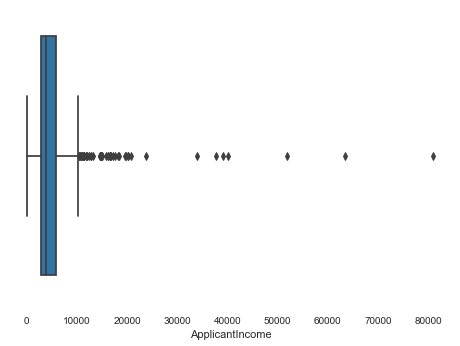

In [28]:
sns.boxplot(loan_train.ApplicantIncome)
plt.show

In [29]:
Q1 = loan_train.ApplicantIncome.quantile(0.05)
Q3 = loan_train.ApplicantIncome.quantile(0.99)
IQR = Q3-Q1

loan_train = loan_train[(loan_train.ApplicantIncome >= Q1 - 1.5*IQR) & (loan_train.ApplicantIncome <= Q3 + 1.5*IQR)]


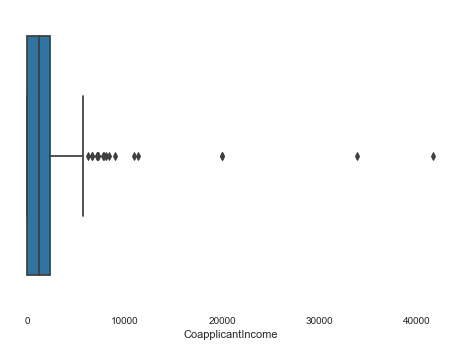

In [30]:
sns.boxplot(loan_train.CoapplicantIncome)
plt.show()

In [31]:
Q1 = loan_train.CoapplicantIncome.quantile(0.05)
Q3 = loan_train.CoapplicantIncome.quantile(0.99)
IQR = Q3-Q1

loan_train = loan_train[(loan_train.CoapplicantIncome >= Q1 - 1.5*IQR) & (loan_train.CoapplicantIncome <= Q3 + 1.5*IQR)]



In [32]:
loan_train.head()

Gender  Married  Education  Self_Employed  ApplicantIncome  \
Loan_ID                                                                
LP001003       1        1          1              0             4583   
LP001005       1        1          1              1             3000   
LP001006       1        1          0              0             2583   
LP001008       1        0          1              0             6000   
LP001011       1        1          1              1             5417   

          CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
Loan_ID                                                                     
LP001003             1508.0       128.0             360.0             1.0   
LP001005                0.0        66.0             360.0             1.0   
LP001006             2358.0       120.0             360.0             1.0   
LP001008                0.0       141.0             360.0             1.0   
LP001011             4196.0       267.0             360.0             1.0   

          Loan_Status  Semiurban  Urban  Dependents_1_kid  Dependents_2_kids  \
Loan_ID                                                                        
LP001003            0          0      0                 1                  0   
LP001005            1          0      1                 0                  0   
LP001006            1          0      1                 0                  0   
LP001008            1          0      1                 0                  0   
LP001011            1          0      1                 0                  1   

          Dependents_No_kid  
Loan_ID                      
LP001003                  0  
LP001005                  1  
LP001006                  1  
LP001008                  1  
LP001011                  0

In [33]:
loan_train.shape

(564, 15)

#### Changing dtype of below mentioned columns

In [34]:
loan_train.CoapplicantIncome = loan_train.CoapplicantIncome.astype(int)
loan_train.LoanAmount = loan_train.LoanAmount.astype(int)
loan_train.Loan_Amount_Term = loan_train.Loan_Amount_Term.astype(int)

In [35]:
loan_train.head()

Gender  Married  Education  Self_Employed  ApplicantIncome  \
Loan_ID                                                                
LP001003       1        1          1              0             4583   
LP001005       1        1          1              1             3000   
LP001006       1        1          0              0             2583   
LP001008       1        0          1              0             6000   
LP001011       1        1          1              1             5417   

          CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
Loan_ID                                                                     
LP001003               1508         128               360             1.0   
LP001005                  0          66               360             1.0   
LP001006               2358         120               360             1.0   
LP001008                  0         141               360             1.0   
LP001011               4196         267               360             1.0   

          Loan_Status  Semiurban  Urban  Dependents_1_kid  Dependents_2_kids  \
Loan_ID                                                                        
LP001003            0          0      0                 1                  0   
LP001005            1          0      1                 0                  0   
LP001006            1          0      1                 0                  0   
LP001008            1          0      1                 0                  0   
LP001011            1          0      1                 0                  1   

          Dependents_No_kid  
Loan_ID                      
LP001003                  0  
LP001005                  1  
LP001006                  1  
LP001008                  1  
LP001011                  0

In [36]:
loan_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 564 entries, LP001003 to LP002990
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             564 non-null    int64  
 1   Married            564 non-null    int64  
 2   Education          564 non-null    int64  
 3   Self_Employed      564 non-null    int64  
 4   ApplicantIncome    564 non-null    int64  
 5   CoapplicantIncome  564 non-null    int64  
 6   LoanAmount         564 non-null    int64  
 7   Loan_Amount_Term   564 non-null    int64  
 8   Credit_History     564 non-null    float64
 9   Loan_Status        564 non-null    int64  
 10  Semiurban          564 non-null    uint8  
 11  Urban              564 non-null    uint8  
 12  Dependents_1_kid   564 non-null    uint8  
 13  Dependents_2_kids  564 non-null    uint8  
 14  Dependents_No_kid  564 non-null    uint8  
dtypes: float64(1), int64(9), uint8(5)
memory usage: 51.2+ KB


### Step 5: Feature Scaling 

In [37]:
scaler = StandardScaler()
loan_train1 = loan_train.copy()
loan_train1[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']] = scaler.fit_transform(loan_train1[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']])


### Step 6: Looking at Correlations Matrix

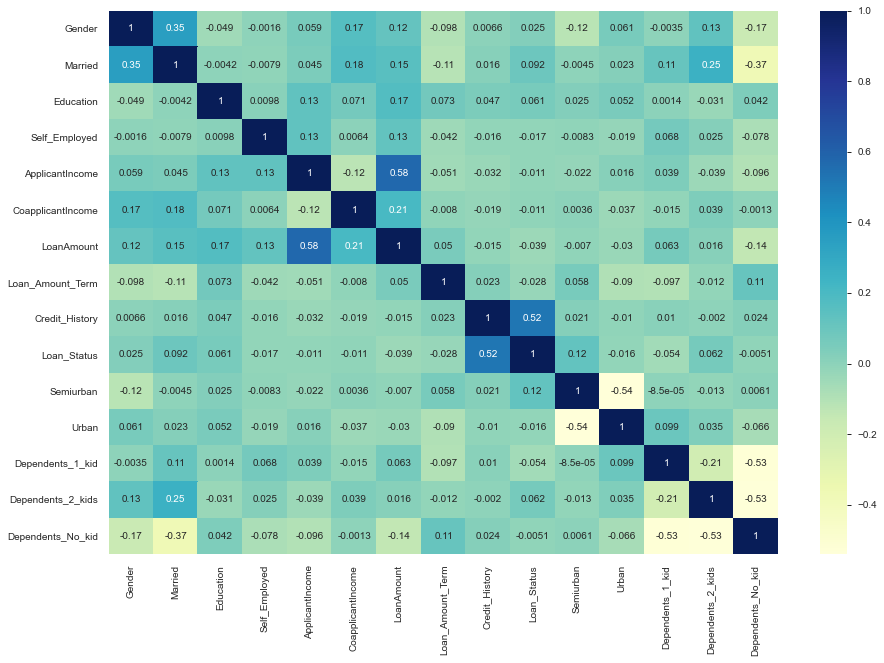

In [38]:
plt.figure(figsize = (15,10))        # Size of the figure
sns.heatmap(loan_train1.corr(),annot = True, cmap='YlGnBu')
plt.show()

In [39]:
y_train = loan_train1['Loan_Status']
X_train = loan_train1

In [40]:
X_train.head()

Gender  Married  Education  Self_Employed  ApplicantIncome  \
Loan_ID                                                                
LP001003       1        1          1              0        -0.142579   
LP001005       1        1          1              1        -0.394235   
LP001006       1        1          0              0        -0.460527   
LP001008       1        0          1              0         0.082688   
LP001011       1        1          1              1        -0.009994   

          CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
Loan_ID                                                                     
LP001003          -0.008862   -0.221150           0.27856             1.0   
LP001005          -0.724679   -0.935991           0.27856             1.0   
LP001006           0.394615   -0.313387           0.27856             1.0   
LP001008          -0.724679   -0.071263           0.27856             1.0   
LP001011           1.267076    1.381479           0.27856             1.0   

          Loan_Status  Semiurban  Urban  Dependents_1_kid  Dependents_2_kids  \
Loan_ID                                                                        
LP001003            0          0      0                 1                  0   
LP001005            1          0      1                 0                  0   
LP001006            1          0      1                 0                  0   
LP001008            1          0      1                 0                  0   
LP001011            1          0      1                 0                  1   

          Dependents_No_kid  
Loan_ID                      
LP001003                  0  
LP001005                  1  
LP001006                  1  
LP001008                  1  
LP001011                  0

#### Dropping Unwanted Columns

In [41]:
X_train.drop(columns='Loan_Status', axis=1, inplace=True)

In [42]:
y_train.head()

Loan_ID
LP001003    0
LP001005    1
LP001006    1
LP001008    1
LP001011    1
Name: Loan_Status, dtype: int64

### Step 7: Model Building

#### Running Your First Training Model

In [43]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Loan_Status   No. Observations:                  564
Model:                            GLM   Df Residuals:                      549
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -257.47
Date:                Thu, 03 Dec 2020   Deviance:                       514.94
Time:                        11:09:59   Pearson chi2:                     563.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.2281      0.681     -4.739      0.000      -4.563      -1.893
Gender                0.0077      0.309      0.025      0.980      -0.599       0.614
Married               0.5300      0.265      1.997      0.046       0.010       1.050
Education             0.3029      0.276      1.097      0.273      -0.238       0.844
Self_Employed        -0.0372      0.330     -0.113      0.910      -0.684       0.610
ApplicantIncome       0.1182      0.154      0.767      0.443      -0.184       0.421
CoapplicantIncome    -0.0111      0.123     -0.091      0.928      -0.252       0.229
LoanAmount           -0.1942      0.142     -1.373      0.170      -0.472       0.083
Loan_Amount_Term     -0.1221      0.127     -0.961      0.336      -0.371       0.127
Credit_History        3.8131      0.429      8.879      0.000       2.971       4.655
Semiurban             0.9555      0.275      3.474      0.001       0.416       1.495
Urban                 0.3967      0.276      1.438      0.150      -0.144       0.937
Dependents_1_kid     -0.7428      0.488     -1.523      0.128      -1.699       0.213
Dependents_2_kids     0.1140      0.513      0.222      0.824      -0.891       1.119
Dependents_No_kid    -0.1886      0.454     -0.415      0.678      -1.078       0.701
=====================================================================================
"""

### Step 8: Feature Selection Using RFE

In [44]:
logreg = LogisticRegression()

In [45]:

rfe = RFE(logreg, 8)             # running RFE with 8 variables as output
rfe = rfe.fit(X_train, y_train)

In [46]:
rfe.support_

array([False,  True,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True, False])

In [47]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Gender', False, 6),
 ('Married', True, 1),
 ('Education', True, 1),
 ('Self_Employed', False, 5),
 ('ApplicantIncome', False, 3),
 ('CoapplicantIncome', False, 7),
 ('LoanAmount', False, 2),
 ('Loan_Amount_Term', True, 1),
 ('Credit_History', True, 1),
 ('Semiurban', True, 1),
 ('Urban', True, 1),
 ('Dependents_1_kid', True, 1),
 ('Dependents_2_kids', True, 1),
 ('Dependents_No_kid', False, 4)]

In [48]:
col = X_train.columns[rfe.support_]

In [49]:
X_train.columns[~rfe.support_]

Index(['Gender', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome',
       'LoanAmount', 'Dependents_No_kid'],
      dtype='object')

#### Assessing the model with StatsModels

In [50]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Loan_Status   No. Observations:                  564
Model:                            GLM   Df Residuals:                      555
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -258.63
Date:                Thu, 03 Dec 2020   Deviance:                       517.25
Time:                        11:09:59   Pearson chi2:                     566.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.3085      0.510     -6.492      0.000      -4.307      -2.310
Married               0.4961      0.240      2.067      0.039       0.026       0.967
Education             0.2429      0.268      0.906      0.365      -0.283       0.768
Loan_Amount_Term     -0.1432      0.126     -1.140      0.254      -0.389       0.103
Credit_History        3.7875      0.425      8.907      0.000       2.954       4.621
Semiurban             0.9655      0.274      3.529      0.000       0.429       1.502
Urban                 0.4171      0.274      1.524      0.128      -0.119       0.954
Dependents_1_kid     -0.5949      0.292     -2.034      0.042      -1.168      -0.022
Dependents_2_kids     0.2551      0.344      0.741      0.459      -0.419       0.930
=====================================================================================
"""

#### Checking VIF

In [51]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
3     Credit_History  4.52
1          Education  3.90
0            Married  2.92
4          Semiurban  2.12
5              Urban  1.94
7  Dependents_2_kids  1.38
6   Dependents_1_kid  1.33
2   Loan_Amount_Term  1.03

In [52]:
col = col.drop('Dependents_2_kids', 1)
col

Index(['Married', 'Education', 'Loan_Amount_Term', 'Credit_History',
       'Semiurban', 'Urban', 'Dependents_1_kid'],
      dtype='object')

In [53]:
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Loan_Status   No. Observations:                  564
Model:                            GLM   Df Residuals:                      556
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -258.91
Date:                Thu, 03 Dec 2020   Deviance:                       517.82
Time:                        11:10:00   Pearson chi2:                     566.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.2877      0.508     -6.472      0.000      -4.283      -2.292
Married              0.5506      0.230      2.398      0.016       0.101       1.001
Education            0.2353      0.267      0.880      0.379      -0.289       0.759
Loan_Amount_Term    -0.1422      0.125     -1.136      0.256      -0.387       0.103
Credit_History       3.7814      0.425      8.906      0.000       2.949       4.614
Semiurban            0.9722      0.274      3.555      0.000       0.436       1.508
Urban                0.4307      0.273      1.578      0.114      -0.104       0.965
Dependents_1_kid    -0.6525      0.283     -2.307      0.021      -1.207      -0.098
====================================================================================
"""

In [54]:
col = col.drop('Education', 1)
col

Index(['Married', 'Loan_Amount_Term', 'Credit_History', 'Semiurban', 'Urban',
       'Dependents_1_kid'],
      dtype='object')

In [55]:
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Loan_Status   No. Observations:                  564
Model:                            GLM   Df Residuals:                      557
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -259.29
Date:                Thu, 03 Dec 2020   Deviance:                       518.58
Time:                        11:10:00   Pearson chi2:                     568.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.1251      0.471     -6.630      0.000      -4.049      -2.201
Married              0.5523      0.230      2.406      0.016       0.102       1.002
Loan_Amount_Term    -0.1334      0.124     -1.074      0.283      -0.377       0.110
Credit_History       3.7896      0.424      8.928      0.000       2.958       4.622
Semiurban            0.9870      0.273      3.614      0.000       0.452       1.522
Urban                0.4570      0.271      1.689      0.091      -0.073       0.987
Dependents_1_kid    -0.6546      0.283     -2.317      0.021      -1.208      -0.101
====================================================================================
"""

In [56]:
col = col.drop('Loan_Amount_Term',1)
col

Index(['Married', 'Credit_History', 'Semiurban', 'Urban', 'Dependents_1_kid'], dtype='object')

In [57]:
X_train_sm = sm.add_constant(X_train[col])
logm5 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Loan_Status   No. Observations:                  564
Model:                            GLM   Df Residuals:                      558
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -259.91
Date:                Thu, 03 Dec 2020   Deviance:                       519.81
Time:                        11:10:00   Pearson chi2:                     567.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.1433      0.472     -6.664      0.000      -4.068      -2.219
Married              0.5798      0.228      2.544      0.011       0.133       1.027
Credit_History       3.7742      0.424      8.907      0.000       2.944       4.605
Semiurban            0.9852      0.273      3.610      0.000       0.450       1.520
Urban                0.4753      0.270      1.761      0.078      -0.054       1.004
Dependents_1_kid    -0.6293      0.281     -2.237      0.025      -1.181      -0.078
====================================================================================
"""

In [58]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

Loan_ID
LP001003    0.641383
LP001005    0.843690
LP001006    0.843690
LP001008    0.751414
LP001011    0.843690
LP001013    0.843690
LP001014    0.171039
LP001018    0.843690
LP001020    0.827301
LP001024    0.843690
dtype: float64

In [59]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.64138291, 0.84369029, 0.84369029, 0.7514144 , 0.84369029,
       0.84369029, 0.17103882, 0.84369029, 0.82730089, 0.84369029])

In [60]:
loan_train.head()

Gender  Married  Education  Self_Employed  ApplicantIncome  \
Loan_ID                                                                
LP001003       1        1          1              0             4583   
LP001005       1        1          1              1             3000   
LP001006       1        1          0              0             2583   
LP001008       1        0          1              0             6000   
LP001011       1        1          1              1             5417   

          CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
Loan_ID                                                                     
LP001003               1508         128               360             1.0   
LP001005                  0          66               360             1.0   
LP001006               2358         120               360             1.0   
LP001008                  0         141               360             1.0   
LP001011               4196         267               360             1.0   

          Loan_Status  Semiurban  Urban  Dependents_1_kid  Dependents_2_kids  \
Loan_ID                                                                        
LP001003            0          0      0                 1                  0   
LP001005            1          0      1                 0                  0   
LP001006            1          0      1                 0                  0   
LP001008            1          0      1                 0                  0   
LP001011            1          0      1                 0                  1   

          Dependents_No_kid  
Loan_ID                      
LP001003                  0  
LP001005                  1  
LP001006                  1  
LP001008                  1  
LP001011                  0

#### Creating a dataframe with the actual churn flag and the predicted probabilities

In [61]:
y_train_pred_final = pd.DataFrame({'Loan_ID': loan_train.index, 'Loan_Status':y_train.values, 'Loan_Status_Prob':y_train_pred})

y_train_pred_final.head()

Loan_ID  Loan_Status  Loan_Status_Prob
0  LP001003            0          0.641383
1  LP001005            1          0.843690
2  LP001006            1          0.843690
3  LP001008            1          0.751414
4  LP001011            1          0.843690

#### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [62]:
y_train_pred_final['predicted'] = y_train_pred_final.Loan_Status_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

Loan_ID  Loan_Status  Loan_Status_Prob  predicted
0  LP001003            0          0.641383          1
1  LP001005            1          0.843690          1
2  LP001006            1          0.843690          1
3  LP001008            1          0.751414          1
4  LP001011            1          0.843690          1

In [63]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Loan_Status, y_train_pred_final.predicted)
print(confusion)

[[ 67 100]
 [  7 390]]


In [64]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Loan_Status, y_train_pred_final.predicted))

0.8102836879432624


In [65]:
TP = confusion[1,1]
FP = confusion[0,1]
TN = confusion[0,0]
FN = confusion[1,0]

In [66]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.982367758186398

In [67]:
# Let us calculate specificity
TN / float(TN+FP)

0.40119760479041916

In [68]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.5988023952095808


In [69]:
# positive predictive value 
print (TP / float(TP+FP))

0.7959183673469388


In [70]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9054054054054054


In [71]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [72]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Loan_Status, y_train_pred_final.Loan_Status_Prob, drop_intermediate = False )


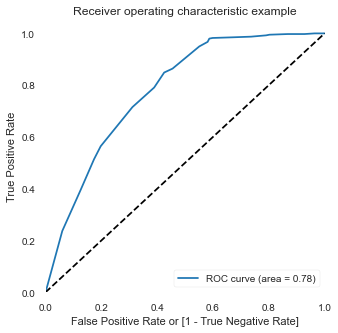

In [73]:
draw_roc(y_train_pred_final.Loan_Status, y_train_pred_final.Loan_Status_Prob)

### Step 10: Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [74]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Loan_Status_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Loan_ID  Loan_Status  Loan_Status_Prob  predicted  0.0  0.1  0.2  0.3  \
0  LP001003            0          0.641383          1    1    1    1    1   
1  LP001005            1          0.843690          1    1    1    1    1   
2  LP001006            1          0.843690          1    1    1    1    1   
3  LP001008            1          0.751414          1    1    1    1    1   
4  LP001011            1          0.843690          1    1    1    1    1   

   0.4  0.5  0.6  0.7  0.8  0.9  
0    1    1    1    0    0    0  
1    1    1    1    1    1    0  
2    1    1    1    1    1    0  
3    1    1    1    1    0    0  
4    1    1    1    1    1    0

In [75]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Loan_Status, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.703901  1.000000  0.000000
0.1   0.1  0.760638  0.992443  0.209581
0.2   0.2  0.810284  0.982368  0.401198
0.3   0.3  0.810284  0.982368  0.401198
0.4   0.4  0.810284  0.982368  0.401198
0.5   0.5  0.810284  0.982368  0.401198
0.6   0.6  0.812057  0.979849  0.413174
0.7   0.7  0.769504  0.863980  0.544910
0.8   0.8  0.634752  0.564232  0.802395
0.9   0.9  0.296099  0.000000  1.000000


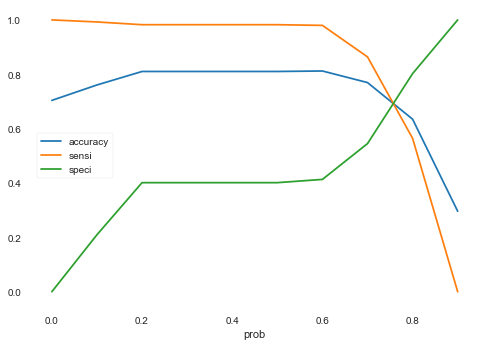

In [76]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.7 is the optimum point to take it as a cutoff probability.

In [77]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Loan_Status_Prob.map( lambda x: 1 if x > 0.7 else 0)

y_train_pred_final.head()

Loan_ID  Loan_Status  Loan_Status_Prob  predicted  0.0  0.1  0.2  0.3  \
0  LP001003            0          0.641383          1    1    1    1    1   
1  LP001005            1          0.843690          1    1    1    1    1   
2  LP001006            1          0.843690          1    1    1    1    1   
3  LP001008            1          0.751414          1    1    1    1    1   
4  LP001011            1          0.843690          1    1    1    1    1   

   0.4  0.5  0.6  0.7  0.8  0.9  final_predicted  
0    1    1    1    0    0    0                0  
1    1    1    1    1    1    0                1  
2    1    1    1    1    1    0                1  
3    1    1    1    1    0    0                1  
4    1    1    1    1    1    0                1

In [78]:
# Let's check the overall accuracy.
round(metrics.accuracy_score(y_train_pred_final.Loan_Status, y_train_pred_final.final_predicted),2)

0.77

In [79]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Loan_Status, y_train_pred_final.final_predicted )
confusion2

array([[ 91,  76],
       [ 54, 343]])

In [80]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [81]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8639798488664987

In [82]:
# Let us calculate specificity
TN / float(TN+FP)

0.5449101796407185

In [83]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.4550898203592814


In [84]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8186157517899761


In [85]:
# Negative predictive value
print (TN / float(TN+ FN))

0.6275862068965518


In [86]:
from sklearn.metrics import precision_score, recall_score

#### Precision

In [87]:
precision_score(y_train_pred_final.Loan_Status, y_train_pred_final.predicted)

0.7959183673469388

#### Recall

In [88]:
recall_score(y_train_pred_final.Loan_Status, y_train_pred_final.predicted)

0.982367758186398

### Precision and recall tradeoff

In [89]:
from sklearn.metrics import precision_recall_curve

In [90]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Loan_Status, y_train_pred_final.Loan_Status_Prob)

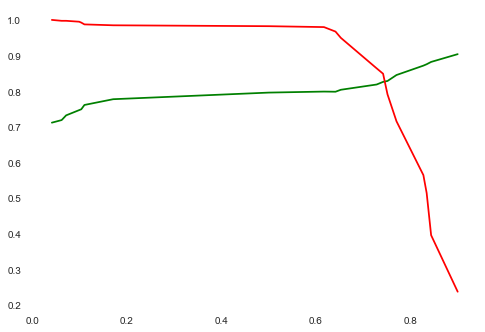

In [91]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Step 9: Predict on Test Set

In [92]:
loan_test = pd.read_csv('test.csv')
loan_test.head()

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001015   Male     Yes          0      Graduate            No   
1  LP001022   Male     Yes          1      Graduate            No   
2  LP001031   Male     Yes          2      Graduate            No   
3  LP001035   Male     Yes          2      Graduate            No   
4  LP001051   Male      No          0  Not Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5720                  0       110.0             360.0   
1             3076               1500       126.0             360.0   
2             5000               1800       208.0             360.0   
3             2340               2546       100.0             360.0   
4             3276                  0        78.0             360.0   

   Credit_History Property_Area  
0             1.0         Urban  
1             1.0         Urban  
2             1.0         Urban  
3             NaN         Urban  
4             1.0         Urban

In [93]:
loan_test.set_index('Loan_ID', inplace = True)

In [94]:
loan_test.shape

(367, 11)

In [95]:
loan_test.Credit_History.fillna(loan_test.Credit_History.mode()[0], inplace = True)

In [96]:
loan_test.Dependents = loan_test.Dependents.map({'0': 'No_kid', "1": '1_kid', '2':'2_kids', '3+': '3+More_kids'})

In [97]:
loan_test.Dependents.fillna(loan_test.Dependents.mode()[0], inplace = True)

In [98]:
varlist = ['Married', 'Self_Employed']
def binary_map(x):
    return x.map({'Yes': 1, "No": 0, 'Y': 1, 'N': 0})


loan_test[varlist] = loan_test[varlist].apply(binary_map)

In [99]:
loan_test.head()

Gender  Married Dependents     Education  Self_Employed  \
Loan_ID                                                            
LP001015   Male        1     No_kid      Graduate            0.0   
LP001022   Male        1      1_kid      Graduate            0.0   
LP001031   Male        1     2_kids      Graduate            0.0   
LP001035   Male        1     2_kids      Graduate            0.0   
LP001051   Male        0     No_kid  Not Graduate            0.0   

          ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
Loan_ID                                                                      
LP001015             5720                  0       110.0             360.0   
LP001022             3076               1500       126.0             360.0   
LP001031             5000               1800       208.0             360.0   
LP001035             2340               2546       100.0             360.0   
LP001051             3276                  0        78.0             360.0   

          Credit_History Property_Area  
Loan_ID                                 
LP001015             1.0         Urban  
LP001022             1.0         Urban  
LP001031             1.0         Urban  
LP001035             1.0         Urban  
LP001051             1.0         Urban

#### Converting Categorical (Male/Female) to Binary (1/0)

In [100]:
loan_test.Gender = loan_test.Gender.apply(lambda x : 1 if x=='Male' else 0)

#### Converting Categorical (Graduate/Not Graduate) to Binary (1/0)

In [101]:
loan_test.Education = loan_test.Education.apply(lambda x : 1 if x=='Graduate' else 0)

#### Creating Dummies for Area of the Property and Dependents

In [102]:
dummy = pd.get_dummies(loan_test.Property_Area, drop_first = True)
loan_test = pd.concat([loan_test, dummy], axis=1)

In [103]:
d1 = pd.get_dummies(loan_test.Dependents, prefix='Dependents')

d1 = d1.drop(['Dependents_3+More_kids'], 1)

loan_test = pd.concat([loan_test, d1], axis=1)

#### Dropping the Original columns after creating their Dummy Columns

In [104]:
loan_test.drop(columns=['Property_Area', 'Dependents'], axis=1, inplace= True)

#### Handling Outliers for Applicant Income and Co Applicant Income Columns

<function matplotlib.pyplot.show(*args, **kw)>

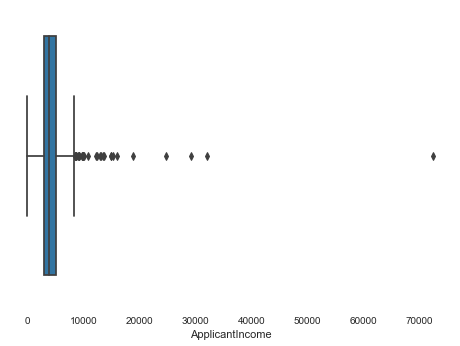

In [105]:
sns.boxplot(loan_test.ApplicantIncome)
plt.show

In [106]:
Q1 = loan_train.ApplicantIncome.quantile(0.05)
Q3 = loan_train.ApplicantIncome.quantile(0.99)
IQR = Q3-Q1

loan_train = loan_train[(loan_train.ApplicantIncome >= Q1 - 1.5*IQR) & (loan_train.ApplicantIncome <= Q3 + 1.5*IQR)]


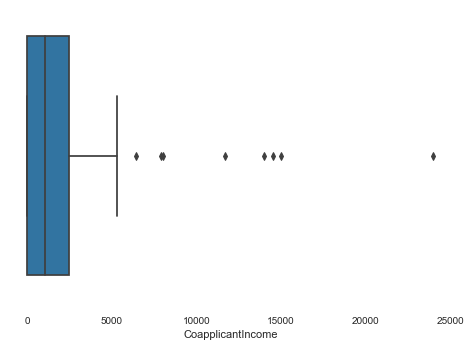

In [107]:
sns.boxplot(loan_test.CoapplicantIncome)
plt.show()

In [108]:
Q1 = loan_train.CoapplicantIncome.quantile(0.05)
Q3 = loan_train.CoapplicantIncome.quantile(0.99)
IQR = Q3-Q1

loan_train = loan_train[(loan_train.CoapplicantIncome >= Q1 - 1.5*IQR) & (loan_train.CoapplicantIncome <= Q3 + 1.5*IQR)]



In [109]:
loan_test.head()

Gender  Married  Education  Self_Employed  ApplicantIncome  \
Loan_ID                                                                
LP001015       1        1          1            0.0             5720   
LP001022       1        1          1            0.0             3076   
LP001031       1        1          1            0.0             5000   
LP001035       1        1          1            0.0             2340   
LP001051       1        0          0            0.0             3276   

          CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
Loan_ID                                                                     
LP001015                  0       110.0             360.0             1.0   
LP001022               1500       126.0             360.0             1.0   
LP001031               1800       208.0             360.0             1.0   
LP001035               2546       100.0             360.0             1.0   
LP001051                  0        78.0             360.0             1.0   

          Semiurban  Urban  Dependents_1_kid  Dependents_2_kids  \
Loan_ID                                                           
LP001015          0      1                 0                  0   
LP001022          0      1                 1                  0   
LP001031          0      1                 0                  1   
LP001035          0      1                 0                  1   
LP001051          0      1                 0                  0   

          Dependents_No_kid  
Loan_ID                      
LP001015                  1  
LP001022                  0  
LP001031                  0  
LP001035                  0  
LP001051                  1

In [110]:
loan_test.shape

(367, 14)

#### Changing dtype of below mentioned columns

In [111]:
loan_test.head()

Gender  Married  Education  Self_Employed  ApplicantIncome  \
Loan_ID                                                                
LP001015       1        1          1            0.0             5720   
LP001022       1        1          1            0.0             3076   
LP001031       1        1          1            0.0             5000   
LP001035       1        1          1            0.0             2340   
LP001051       1        0          0            0.0             3276   

          CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
Loan_ID                                                                     
LP001015                  0       110.0             360.0             1.0   
LP001022               1500       126.0             360.0             1.0   
LP001031               1800       208.0             360.0             1.0   
LP001035               2546       100.0             360.0             1.0   
LP001051                  0        78.0             360.0             1.0   

          Semiurban  Urban  Dependents_1_kid  Dependents_2_kids  \
Loan_ID                                                           
LP001015          0      1                 0                  0   
LP001022          0      1                 1                  0   
LP001031          0      1                 0                  1   
LP001035          0      1                 0                  1   
LP001051          0      1                 0                  0   

          Dependents_No_kid  
Loan_ID                      
LP001015                  1  
LP001022                  0  
LP001031                  0  
LP001035                  0  
LP001051                  1

In [112]:
loan_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367 entries, LP001015 to LP002989
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             367 non-null    int64  
 1   Married            367 non-null    int64  
 2   Education          367 non-null    int64  
 3   Self_Employed      344 non-null    float64
 4   ApplicantIncome    367 non-null    int64  
 5   CoapplicantIncome  367 non-null    int64  
 6   LoanAmount         362 non-null    float64
 7   Loan_Amount_Term   361 non-null    float64
 8   Credit_History     367 non-null    float64
 9   Semiurban          367 non-null    uint8  
 10  Urban              367 non-null    uint8  
 11  Dependents_1_kid   367 non-null    uint8  
 12  Dependents_2_kids  367 non-null    uint8  
 13  Dependents_No_kid  367 non-null    uint8  
dtypes: float64(4), int64(5), uint8(5)
memory usage: 30.5+ KB


### Feature Scaling 

In [113]:
scaler = StandardScaler()
loan_test1 = loan_test.copy()
loan_test1[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']] = scaler.fit_transform(loan_test1[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']])


In [114]:
loan_test1 = loan_test1[col]
loan_test1.head()

Married  Credit_History  Semiurban  Urban  Dependents_1_kid
Loan_ID                                                              
LP001015        1             1.0          0      1                 0
LP001022        1             1.0          0      1                 1
LP001031        1             1.0          0      1                 0
LP001035        1             1.0          0      1                 0
LP001051        0             1.0          0      1                 0

In [115]:
loan_test1_sm = sm.add_constant(loan_test1)

In [116]:
y_test_pred = res.predict(loan_test1_sm)

In [117]:
y_test_pred = pd.DataFrame(y_test_pred, columns=['Loan_Status_Prob'])

In [118]:
y_test_pred.columns

Index(['Loan_Status_Prob'], dtype='object')

In [119]:
y_test_pred

Loan_Status_Prob
Loan_ID                   
LP001015          0.843690
LP001022          0.742056
LP001031          0.843690
LP001035          0.843690
LP001051          0.751414
...                    ...
LP002971          0.843690
LP002975          0.843690
LP002980          0.834257
LP002986          0.770411
LP002989          0.652684

[367 rows x 1 columns]

In [120]:
y_test_pred['Loan_Status'] = y_test_pred.Loan_Status_Prob.map( lambda x: 1 if x > 0.7 else 0)

y_test_pred.head()

Loan_Status_Prob  Loan_Status
Loan_ID                                
LP001015          0.843690            1
LP001022          0.742056            1
LP001031          0.843690            1
LP001035          0.843690            1
LP001051          0.751414            1

In [121]:
y_test_pred.drop(columns=['Loan_Status_Prob'], axis=1, inplace=True)
y_test_pred

Loan_Status
Loan_ID              
LP001015            1
LP001022            1
LP001031            1
LP001035            1
LP001051            1
...               ...
LP002971            1
LP002975            1
LP002980            1
LP002986            1
LP002989            0

[367 rows x 1 columns]

In [122]:
def submission_map(x):
    if x==1:
        return 'Y'
    else:
        return 'N'

In [123]:
submission_map(0)

'N'

In [124]:
y_test_pred.Loan_Status = y_test_pred.Loan_Status.apply(submission_map)

In [125]:
y_test_pred

Loan_Status
Loan_ID             
LP001015           Y
LP001022           Y
LP001031           Y
LP001035           Y
LP001051           Y
...              ...
LP002971           Y
LP002975           Y
LP002980           Y
LP002986           Y
LP002989           N

[367 rows x 1 columns]

In [126]:
#pwd

In [127]:
#y_test_pred.to_csv('/Users/renubakshi/Analytics Vidhya Hackatons/Loan Prediction/basic_result.csv')

In [128]:
# Importing required packages for visualization
from IPython.display import Image  

from sklearn.tree import export_graphviz
import pydotplus, graphviz

from six import StringIO

In [129]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [130]:
def get_dt_graph(dt_classifier):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X_train.columns, 
                    class_names=['Loan_approved', "Loan_declined"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [131]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))

In [132]:
from sklearn.tree import DecisionTreeClassifier

In [133]:
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

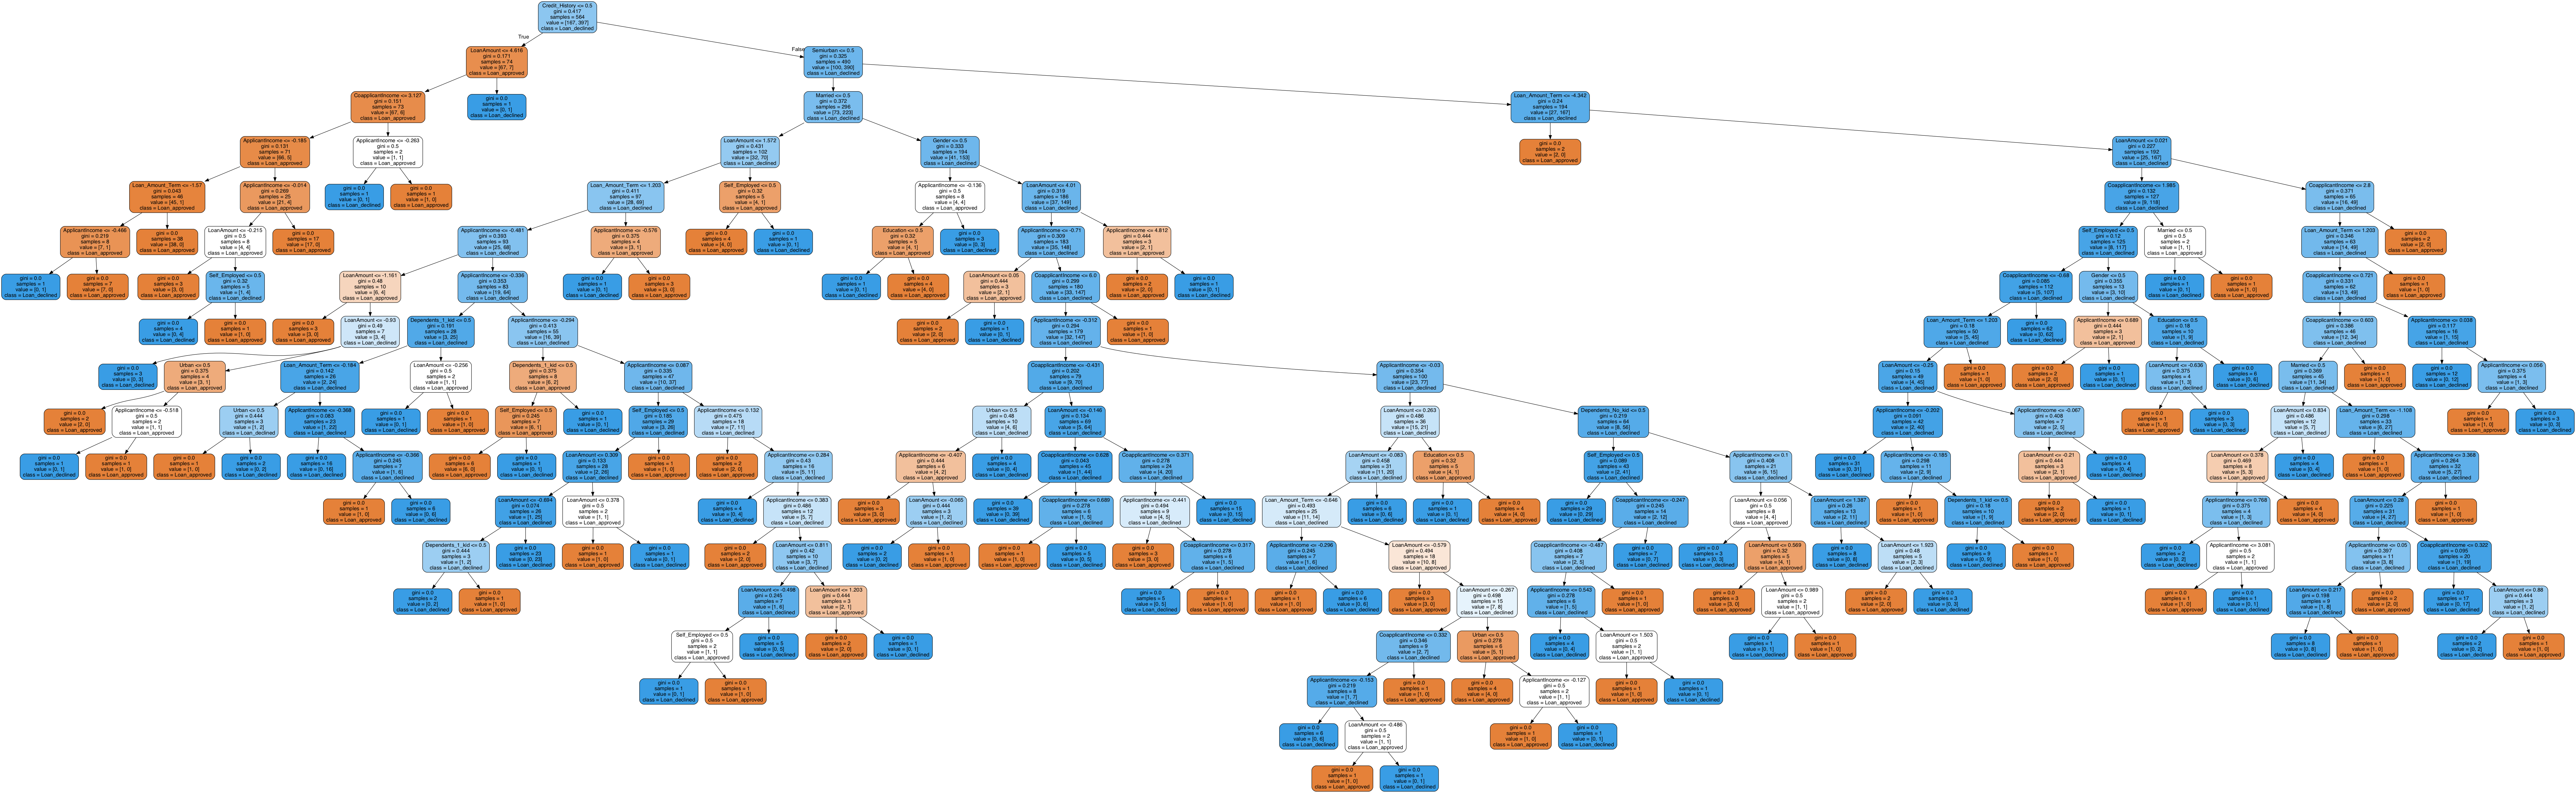

In [134]:
gph = get_dt_graph(dt_default)
Image(gph.create_png())

In [135]:
evaluate_model(dt_default)

Train Accuracy : 1.0
Train Confusion Matrix:
[[167   0]
 [  0 397]]


In [136]:
dt_min_split = DecisionTreeClassifier(min_samples_split=200)
dt_min_split.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=200)

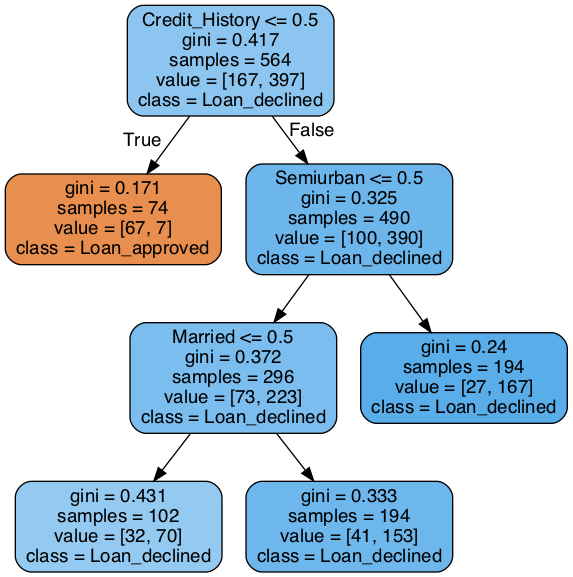

In [137]:
gph = get_dt_graph(dt_min_split) 
Image(gph.create_png())

In [138]:
evaluate_model(dt_min_split)

Train Accuracy : 0.8102836879432624
Train Confusion Matrix:
[[ 67 100]
 [  7 390]]


In [139]:
dt_min_leaf = DecisionTreeClassifier(min_samples_leaf=60, random_state=42)
dt_min_leaf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=60, random_state=42)

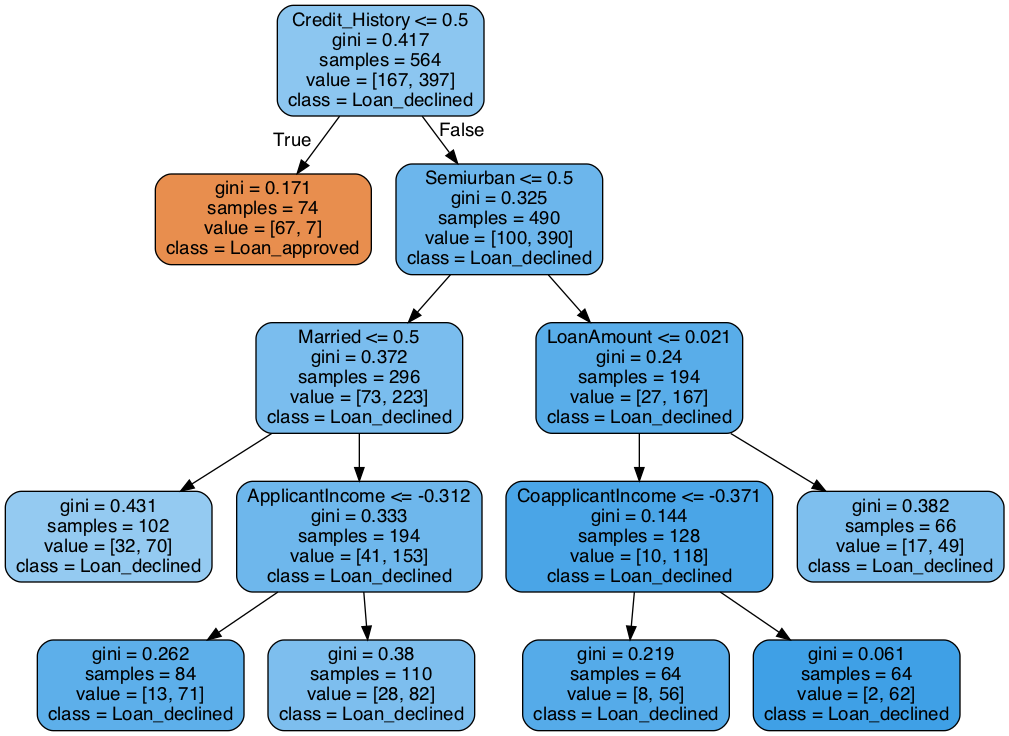

In [140]:
gph = get_dt_graph(dt_min_leaf)
Image(gph.create_png())

In [141]:
evaluate_model(dt_min_leaf)

Train Accuracy : 0.8102836879432624
Train Confusion Matrix:
[[ 67 100]
 [  7 390]]


In [142]:
dt = DecisionTreeClassifier(random_state=42)

In [143]:
from sklearn.model_selection import GridSearchCV

In [144]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [145]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [146]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s


CPU times: user 614 ms, sys: 109 ms, total: 723 ms
Wall time: 4.89 s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [147]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, random_state=42)

In [148]:
dt_best = grid_search.best_estimator_

In [149]:
evaluate_model(dt_best)

Train Accuracy : 0.8102836879432624
Train Confusion Matrix:
[[ 67 100]
 [  7 390]]


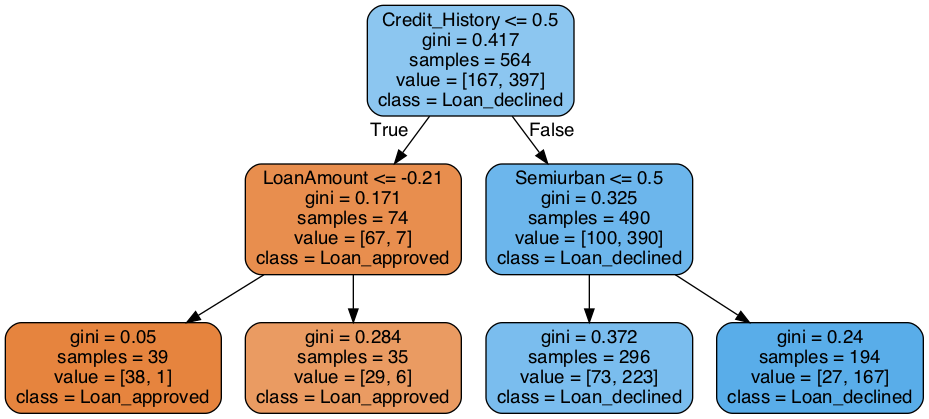

In [150]:
gph = get_dt_graph(dt_best)
Image(gph.create_png())

In [151]:
from sklearn.ensemble import RandomForestClassifier

In [152]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=5, random_state=100, oob_score=True)

In [153]:
%%time
rf.fit(X_train, y_train)

CPU times: user 34.3 ms, sys: 4.04 ms, total: 38.3 ms
Wall time: 39 ms


RandomForestClassifier(max_depth=4, max_features=5, n_estimators=10,
                       oob_score=True, random_state=100)

In [154]:
rf.oob_score_

0.7978723404255319

In [155]:
from sklearn.metrics import plot_roc_curve

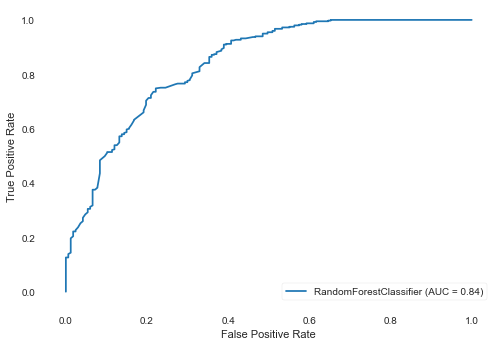

In [156]:
plot_roc_curve(rf, X_train, y_train)
plt.show()

In [157]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [158]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [159]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [160]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.4s


CPU times: user 3.03 s, sys: 178 ms, total: 3.21 s
Wall time: 39.8 s


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   39.7s finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [161]:
grid_search.best_score_

0.8120567375886525

In [162]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)

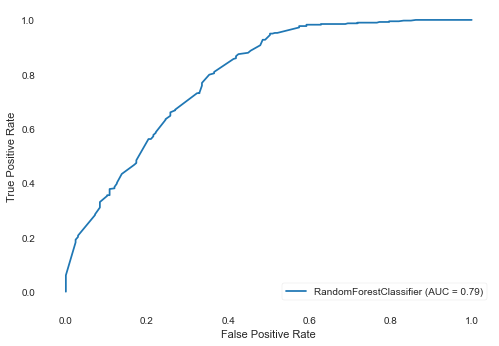

In [163]:
plot_roc_curve(rf_best, X_train, y_train)
plt.show()

In [164]:
rf_best.feature_importances_

array([0.        , 0.02561536, 0.        , 0.0013667 , 0.11548729,
       0.        , 0.0215437 , 0.06963975, 0.53348654, 0.09959914,
       0.02129715, 0.        , 0.0776609 , 0.03430348])

In [165]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [166]:
imp_df.sort_values(by="Imp", ascending=False)

Varname       Imp
8      Credit_History  0.533487
4     ApplicantIncome  0.115487
9           Semiurban  0.099599
12  Dependents_2_kids  0.077661
7    Loan_Amount_Term  0.069640
13  Dependents_No_kid  0.034303
1             Married  0.025615
6          LoanAmount  0.021544
10              Urban  0.021297
3       Self_Employed  0.001367
0              Gender  0.000000
2           Education  0.000000
5   CoapplicantIncome  0.000000
11   Dependents_1_kid  0.000000